In [1]:
using Plots
gr()#size=(480, 360), dpi=20)

using NLsolve
using ForwardDiff

using BenchmarkTools

In [2]:
const Δx = 2. / 200
const x = 0.:Δx:2.-Δx

const Δt = 0.02

0.02

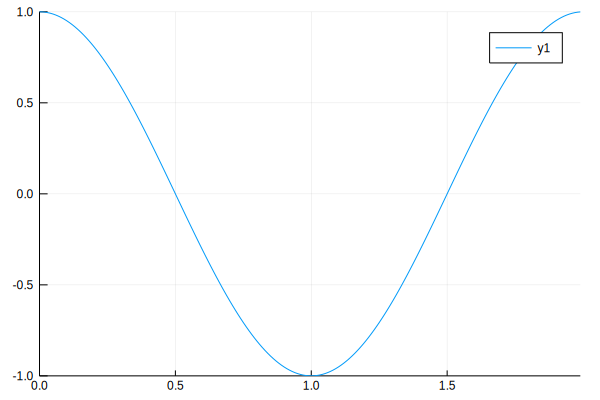

In [3]:
u = cos.(pi*x)
plot(x, u)

In [4]:
mutable struct GenerateUt{T}
    Δx::T
end

function (self::GenerateUt)(r::Vector, u::Vector)
    Δx = self.Δx
    N = length(u)
    for i in 3:N-2
        r[i] = (
            - u[i] * (u[i+1]-u[i-1]) / 2Δx
            - 0.022^2 / 2Δx^3 * (u[i+2]-2u[i+1]+2u[i-1]-u[i-2]) )
    end
    
    um(i) = u[1 + mod(i-1, N)]
    for i in [N-1, N, 1, 2]
        r[i] = (
            - um(i) * (um(i+1)-um(i-1)) / 2Δx
            - 0.022^2 / 2Δx^3 * (um(i+2)-2um(i+1)+2um(i-1)-um(i-2)) )
    end
end

u_t! = GenerateUt(Δx)

function u_t(u::Vector)
    r = similar(u)
    u_t!(r, u)
    return r
end

u_t (generic function with 1 method)

In [5]:
mutable struct GenerateF{T}
    u::Vector{T}
    Δt::T
end

function (self::GenerateF)(r::Vector, un::Vector)
    r .= (u_t(self.u) .+ u_t(un)) ./ 2
    for i in 1:length(un)
        r[i] -= (un[i] - self.u[i]) / self.Δt
    end
end

f! = GenerateF(u, Δt)

function f(u)
    r = similar(u)
    f!(r, u)
    return r
end

f (generic function with 1 method)

In [6]:
function kdv_nlsolve(Δt::Float64=0.02)
    Δx = 2. / 200
    x = 0.:Δx:2.-Δx
    u = cos.(pi*x)
    f! = GenerateF(u, Δt)
    
    num_loop = round(Int64, abs(1.2/Δt))#3.6/pi/Δt)
    for i in 1:num_loop
        u = nlsolve(f!, u, autodiff = :forward, method = :newton).zero
        f!.u = u
    end
    return u
end

kdv_nlsolve (generic function with 2 methods)

 21.810524 seconds (24.86 M allocations: 1.242 GiB, 2.49% gc time)


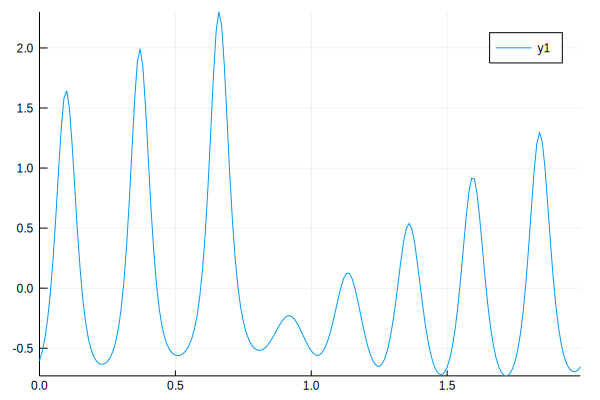

In [7]:
@time u = kdv_nlsolve(0.02);
plot(x, u)

In [8]:
mutable struct GenerateJ{T}
    Δx::T
    Δt::T
end

function (self::GenerateJ)(rr, u::Vector)
    fill!(rr, 0.)
    N = length(u)
    Δx = self.Δx
    ix(i) = 1 + mod(i-1, N)
    a = 0.022^2 / 2Δx^3
    for i in 1:N # row
        rr[i, ix(i-2)] =   a / 2
        rr[i, ix(i-1)] =   4Δx \ u[i] - a
        rr[i, ix(i)  ] = - 4Δx \ (u[ix(i+1)]-u[ix(i-1)]) - 1 / self.Δt
        rr[i, ix(i+1)] = - 4Δx \ u[i] + a
        rr[i, ix(i+2)] = - a / 2
    end
end

j! = GenerateJ(Δx, Δt)

function j(u)
    r = zeros((length(u), length(u)))
    j!(r, u)
    return r
end

j (generic function with 1 method)

In [9]:
function kdv(Δt::Float64=0.02)
    N = 200
    Δx = 2. / N
    x = 0.:Δx:2.-Δx
    u = cos.(pi*x)
    f! = GenerateF(u, Δt)
    j! = GenerateJ(Δx, Δt)
    res = zeros(N)
    jac = zeros((N, N))
    
    num_loop = round(Int64, abs(1.2/Δt))#3.6/pi/Δt)
    for time_count in 1:num_loop
        f!(res, u)
        for newton_count in 1:20
            j!(jac, u)
            u -= sparse(jac) \ res
            f!(res, u)
            sum(abs, res) < 1e-8 && break
        end
        f!.u = u
    end
    return u
end

kdv (generic function with 2 methods)

  1.073877 seconds (290.22 k allocations: 82.867 MiB, 2.40% gc time)


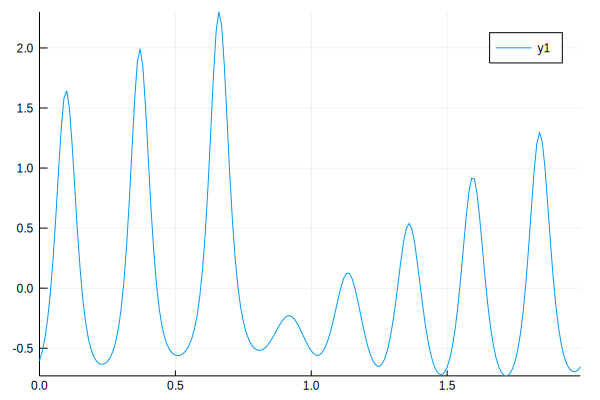

In [10]:
@time u = kdv(0.02);
plot(x, u)

In [89]:
function kdv2(Δt::Float64=0.02, t_max::Float64=1.2,
                u::Vector{Float64}=cos.(pi*(0.:0.01:1.99)) )
    N = length(u)
    Δx = 2. / N
    f! = GenerateF(u, Δt)
    j! = GenerateJ(Δx, Δt)
    res = zeros(N)
    jac = zeros((N, N))
    
    num_loop = round(Int64, abs(t_max/Δt))#3.6/pi/Δt)
    for time_count in 1:num_loop
        f!(res, u)
        for newton_count in 1:20
            j!(jac, u)
            u -= sparse(jac) \ res
            f!(res, u)
            sum(abs, res) < 1e-8 && break
        end
        f!.u = u
    end
    return u
end

kdv2 (generic function with 4 methods)

  0.108332 seconds (20.57 k allocations: 77.185 MiB, 9.05% gc time)


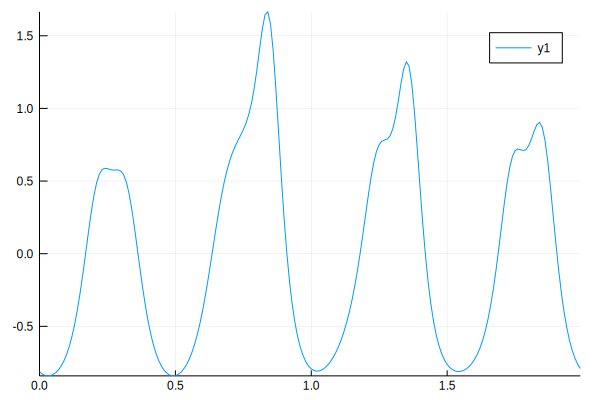

In [88]:
@time u = kdv2(-0.02, 1.2, u)
plot(x, u)

In [100]:
function kdv_all(Δt::Float64=0.02, t_max::Float64=1.2,
                u::Vector{Float64}=cos.(pi*(0.:0.01:1.99)) )
    N = length(u)
    Δx = 2. / N
    f! = GenerateF(u, Δt)
    j! = GenerateJ(Δx, Δt)
    res = zeros(N)
    jac = zeros((N, N))
    u_hist = Array{Float64, 2}(N, 0)
    
    num_loop = round(Int64, abs(t_max/Δt))#3.6/pi/Δt)
    for time_count in 1:num_loop
        f!(res, u)
        for newton_count in 1:20
            j!(jac, u)
            u -= sparse(jac) \ res
            f!(res, u)
            sum(abs, res) < 1e-8 && break
        end
        f!.u = u
        u_hist = hcat(u_hist, u)
    end
    return u_hist
end

kdv_all (generic function with 4 methods)

In [101]:
@code_warntype kdv_all()

Variables:
  #self#::#kdv_all
  T <optimized out>
  shape <optimized out>
  iter <optimized out>
  C::Array{Float64,1}
  keeps@_6::Tuple{Tuple{Bool}}
  Idefaults@_7::Tuple{Tuple{Int64}}
  #temp#@_8 <optimized out>
  keeps@_9 <optimized out>
  Idefaults@_10 <optimized out>
  #temp#@_11 <optimized out>
  keep@_12::Tuple{Bool}
  Idefault@_13::Tuple{Int64}
  #temp#@_14 <optimized out>
  ind1 <optimized out>
  keep@_16 <optimized out>
  Idefault@_17 <optimized out>
  #temp#@_18 <optimized out>
  I_1 <optimized out>
  val_1::Float64
  result::Float64
  I@_22 <optimized out>
  i#664::Int64
  I@_24 <optimized out>
  n#663::Int64
  i#662 <optimized out>
  #temp#@_27::Bool
  r#661 <optimized out>
  A_1 <optimized out>
  keep_1::Tuple{Bool}
  Idefault_1::Tuple{Int64}
  u@_32::Int64
  shift_hi <optimized out>
  shift_lo <optimized out>
  x_hi <optimized out>
  x_lo <optimized out>
  #temp#@_37 <optimized out>
  #temp#@_38 <optimized out>
  w::Float64
  u@_40::Float64
  v::Float64
  #temp#@_42::Flo

In [102]:
u_hist = kdv_all()

200×60 Array{Float64,2}:
 0.998095  0.992469  0.983371  …  -0.617385   -0.611004   -0.604797 
 0.999553  0.99582   0.988493     -0.538922   -0.532984   -0.527496 
 1.00003   0.998221  0.992719     -0.424344   -0.419085   -0.414718 
 0.99952   0.999659  0.996028     -0.259918   -0.256937   -0.255278 
 0.998017  1.00012   0.998402     -0.0360782  -0.0360184  -0.03783  
 0.995518  0.999595  0.999823  …   0.257701    0.253012    0.245946 
 0.992018  0.99807   1.00027       0.614566    0.604769    0.592235 
 0.987516  0.995536  0.999733      1.00743     0.992371    0.974524 
 0.982011  0.991983  0.998188      1.36995     1.35261     1.33306  
 0.975501  0.987402  0.99562       1.61403     1.59879     1.58238  
 0.967987  0.981787  0.992013  …   1.65942     1.65193     1.64481  
 0.959472  0.97513   0.987352      1.49284     1.49545     1.49956  
 0.949959  0.967426  0.981624      1.17073     1.18268     1.19703  
 ⋮                             ⋱                                    
 0.907487

In [103]:
ENV["PLOTS_TEST"] = "true"

"true"

In [104]:
anim = @animate for i=1:60
    plot(x, u_hist[:, i])
end

Plots.Animation("/var/folders/xh/5k9bd7c51yj59nldxpdy97wc0000gn/T/tmpbHdPtp", String["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000051.png", "000052.png", "000053.png", "000054.png", "000055.png", "000056.png", "000057.png", "000058.png", "000059.png", "000060.png"])

In [107]:
gif(anim, "kdv.gif", fps=10)

LoadError: [91mcould not spawn `ffmpeg -v 0 -i /var/folders/xh/5k9bd7c51yj59nldxpdy97wc0000gn/T/tmpbHdPtp/%06d.png -vf palettegen=stats_mode=diff -y /var/folders/xh/5k9bd7c51yj59nldxpdy97wc0000gn/T/tmpbHdPtp/palette.bmp`: no such file or directory (ENOENT)[39m

In [121]:
@benchmark sparse(j(u)) \ f(u)

BenchmarkTools.Trial: 
  memory estimate:  643.58 KiB
  allocs estimate:  84
  --------------
  minimum time:     392.546 μs (0.00% GC)
  median time:      562.780 μs (0.00% GC)
  mean time:        659.663 μs (11.80% GC)
  maximum time:     6.620 ms (78.48% GC)
  --------------
  samples:          7499
  evals/sample:     1

In [111]:
using IDRsSolver

In [113]:
@benchmark idrs(sparse(j(u)), f(u))

BenchmarkTools.Trial: 
  memory estimate:  9.96 MiB
  allocs estimate:  21272
  --------------
  minimum time:     32.482 ms (0.00% GC)
  median time:      37.186 ms (0.00% GC)
  mean time:        37.614 ms (3.93% GC)
  maximum time:     46.631 ms (8.37% GC)
  --------------
  samples:          133
  evals/sample:     1

In [114]:
@time idrs(sparse(j(u)), f(u))

  0.039020 seconds (22.36 k allocations: 10.475 MiB, 8.21% gc time)


([-1.83986, -1.84405, -1.84049, -1.83194, -1.81569, -1.79363, -1.763, -1.72495, -1.67695, -1.61967  …  -1.05447, -1.24907, -1.40527, -1.52925, -1.62251, -1.69429, -1.74604, -1.78526, -1.81155, -1.83032], IDRsSolver.ConvergenceHistory{Float64,Array{Float64,1}}(true, 3.371747880871523e-7, 305, [762.014, 195.145, 32.1147, 34.9262, 37.0663, 71.9632, 110.909, 219.298, 18.7738, 21.641  …  1.27713e-6, 3.00721e-6, 3.50061e-6, 6.15582e-7, 6.86588e-7, 1.1802e-6, 3.47612e-6, 7.87134e-7, 4.65777e-6, 2.50287e-7]))

In [117]:
using KrylovMethods

In [120]:
@time cgls(sparse(j(u)), f(u))

  0.002178 seconds (187 allocations: 359.844 KiB)


([-1.83987, -1.84405, -1.84049, -1.83194, -1.81569, -1.79363, -1.763, -1.72495, -1.67695, -1.61967  …  -1.05447, -1.24907, -1.40527, -1.52925, -1.62251, -1.69429, -1.74604, -1.78526, -1.81155, -1.83032], 0, [15.012, 15.1497, 15.196, 15.2332, 15.2544, 15.2674, 15.2763, 15.2824, 15.2865, 15.2897  …  15.3015, 15.3015, 15.3015, 15.3015, 15.3015, 15.3015, 15.3015, 15.3015, 15.3015, 15.3015], [84.5352, 55.4911, 44.9155, 35.121, 28.5623, 23.8272, 20.1129, 17.2149, 15.0041, 13.1028  …  0.00317053, 0.00265863, 0.00199883, 0.00171011, 0.00154002, 0.00140592, 0.0012459, 0.000959181, 0.000779052, 0.000655774], [1.74793e7, 2.22508e8, 9.09464e7, 6.24672e7, 3.81667e7, 1.96812e7, 1.3268e7, 9.17604e6, 6.30409e6, 4.73954e6  …  0.314999, 0.340403, 0.259287, 0.0472416, 0.042025, 0.0343365, 0.0454687, 0.050318, 0.0258644, 0.0145654])

In [122]:
@benchmark cgls(sparse(j(u)), f(u))

BenchmarkTools.Trial: 
  memory estimate:  359.72 KiB
  allocs estimate:  184
  --------------
  minimum time:     1.928 ms (0.00% GC)
  median time:      2.250 ms (0.00% GC)
  mean time:        2.311 ms (2.29% GC)
  maximum time:     6.427 ms (59.42% GC)
  --------------
  samples:          2158
  evals/sample:     1

In [123]:
@benchmark bicgstb(sparse(j(u)), f(u))

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06e-02 instead of tol=1.00e-06.
bicgstb iterated maxIter (=100) times but reached only residual norm 2.06

LoadError: [91mInterruptException:[39m